In [ ]:
import sys
import random

import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import importlib
from einops import rearrange, reduce, repeat
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def exists(val):
    return val is not None

class MyViTransformerWrapper(nn.Module):
    def __init__(
            self,
            *,
            image_size,
            patch_size,
            attn_layers,
            channels,
            num_classes = None,
            dropout = 0.,
            post_emb_norm = False,
            emb_dropout = 0.
    ):
        super().__init__()
        assert isinstance(attn_layers, Encoder), 'attention layers must be an Encoder'
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        dim = attn_layers.dim
        print("dim: ", dim)
        num_patches = (image_size // patch_size)
        patch_dim = channels * patch_size

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(num_patches, dim))

        self.patch_to_embedding = nn.Sequential(
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim)
        )

        self.post_emb_norm = nn.LayerNorm(dim) if post_emb_norm else nn.Identity()
        self.dropout = nn.Dropout(emb_dropout)

        self.attn_layers = attn_layers
        self.norm = nn.LayerNorm(dim)
        self.mlp_head = nn.Linear(dim, num_classes) if exists(num_classes) else nn.Identity()

    def forward(
            self,
            img,
            return_embeddings = False
    ):
        p = self.patch_size
        img = img.unsqueeze(-2)
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = 1, p2 = p)
        x = self.patch_to_embedding(x)
        n = x.shape[1]
        x = x + self.pos_embedding

        x = self.post_emb_norm(x)
        x = self.dropout(x)

        x = self.attn_layers(x)
        x = self.norm(x)

        if not exists(self.mlp_head) or return_embeddings:
            return x

        x = x.mean(dim = -2)
        return self.mlp_head(x)

class LinearWithConstraint(nn.Linear):
    def __init__(self, *config, max_norm=1, **kwconfig):
        self.max_norm = max_norm
        super(LinearWithConstraint, self).__init__(*config, **kwconfig)

    def forward(self, x):
        self.weight.data = torch.renorm(
            self.weight.data, p=2, dim=0, maxnorm=self.max_norm
        )
        return super(LinearWithConstraint, self).forward(x)

In [ ]:
from utils.utils import initialize_weight
from base.layers import Conv2dWithConstraint
import math

import torch
from torch import nn
import torch.nn.functional as F
import torch
from x_transformers import TransformerWrapper, Encoder, ViTransformerWrapper


class FeatureExtraction(nn.Module):
    def __init__(
            self,
            n_channels,
            kernel_length,
            F1,
            D,
            F2,
            pool1_stride,
            pool2_stride,
            dropout_rate,
            weight_init_method=None
    ):
        super().__init__()

        # Spectral
        self.rearrange = Rearrange('b c w -> b 1 c w')
        self.conv1 = nn.Conv2d(1, F1, (1, kernel_length), bias=False, padding='same')
        self.batch1 = nn.BatchNorm2d(F1)

        # Spatial
        self.conv2 = Conv2dWithConstraint(F1, F1 * D, (n_channels, 1), bias=False, groups=F1)
        self.batch2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.avgpool1 = nn.AvgPool2d((1, pool1_stride))
        self.dropout1 = nn.Dropout(dropout_rate)

        # Temporal
        self.conv3 = nn.Conv2d(F1 * D, F2, (1, n_channels), bias=False, padding='same', groups=F2)
        self.conv4 = nn.Conv2d(F2, F2, 1, bias=False)
        self.batch3 = nn.BatchNorm2d(F2)
        self.activation2 = nn.ELU()
        self.avgpool2 = nn.AvgPool2d((1, pool2_stride))
        self.dropout2 = nn.Dropout(dropout_rate)

        # Classifier
        self.flatten = nn.Flatten()

        initialize_weight(self, weight_init_method)

    def forward(self, x):
        # print(x.shape)
        out = self.rearrange(x)
        # print(out.shape)
        out = self.conv1(out)
        # print(out.shape)
        out = self.batch1(out)
        # print(out.shape)

        # Spatial
        out = self.conv2(out)
        # print(out.shape)
        out = self.batch2(out)
        # print(out.shape)
        out = self.activation1(out)
        # print(out.shape)
        out = self.avgpool1(out)
        # print(out.shape)
        out = self.dropout1(out)
        # print(out.shape)

        # Temporal
        out = self.conv3(out)
        # print(out.shape)
        out = self.conv4(out)
        # print(out.shape)
        out = self.batch3(out)
        # print(out.shape)
        out = self.activation2(out)
        # print(out.shape)
        out = self.avgpool2(out)
        # print(out.shape)
        out = self.dropout2(out)
        # print(out.shape)
        out = self.flatten(out)
        # print(out.shape)

        return out


In [151]:
from einops.layers.torch import Reduce
from x_transformers import ContinuousTransformerWrapper
from einops.layers.torch import Rearrange

class EEGNET(nn.Module):
    def __init__(
            self,
            n_times,
            n_classes,
            n_channels,
            patches_size=5,
            transformer_dim=4,
            transformer_layers=1,
            transformer_heads=1,
            dropout_rate=0.5,
            max_norm=0.25,
            F1=8,
            F2=16,
            D=2,
            pool1_stride=8,
            pool2_stride=8,
            kernel_length=62,
            n_hidden=4,
    ):
        super().__init__()
        self.feature_extraction_output = F2 * ((((n_times - pool1_stride) // pool1_stride + 1) - pool2_stride) // pool2_stride + 1)

        self.feature_extraction = nn.Sequential(
            FeatureExtraction(n_channels=n_channels, kernel_length=kernel_length, F1=F1, D=D, F2=F2, pool1_stride=pool1_stride, pool2_stride=pool2_stride, dropout_rate=dropout_rate),
            nn.Linear(in_features=self.feature_extraction_output, out_features=n_hidden),
            nn.ELU(),
        )

        self.transformer = nn.Sequential(
            MyViTransformerWrapper(
                image_size=n_times,
                patch_size=patches_size,
                channels=n_channels,
                dropout=dropout_rate,
                attn_layers= Encoder(
                    dim=transformer_dim,
                    depth=transformer_layers,
                    heads=transformer_heads,
                    macaron=True,
                    rel_pos_bias=True,
                    attn_dim_head = 1,
                    value_dim_head=1,
                    dim_head=1,
                    ff_mult=1,
                ),
            ),
            nn.Linear(in_features=transformer_dim, out_features=n_hidden),
            nn.ELU(),
        )

        self.spatial_transformer = nn.Sequential(
            # Rearrange("b c t -> b 1 c t"),
            # nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(8, 32), groups=1),
            # nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(8, 32), groups=1),
            # nn.AdaptiveAvgPool2d((8, 64)),
            # Rearrange("b 1 c t -> b t c"),

            nn.AdaptiveAvgPool1d(2), #layer do stop overfit
            Rearrange("b c t -> b t c"),
            MyViTransformerWrapper(
                image_size=n_channels,
                patch_size=n_channels//2,
                channels=2,
                dropout=dropout_rate,
                attn_layers=Encoder(
                    dim=transformer_dim,
                    depth=transformer_layers,
                    heads=transformer_heads,
                    macaron=True,
                    rel_pos_bias=True,
                    attn_dim_head = 32,
                ),
            ),
            # nn.LayerNorm(transformer_dim),
            # nn.Dropout(dropout_rate),
            nn.Linear(in_features=transformer_dim, out_features=n_hidden),
            nn.ELU(),
        )

        self.head = nn.Sequential(
            LinearWithConstraint(in_features=3*n_hidden, out_features=n_classes, max_norm=max_norm),
        )

    def forward(self, x, targets):
        out_values = {}
        feature_extraction_result = self.feature_extraction(x)
        transformer_result = self.transformer(x)
        spatial_transformer_result = self.spatial_transformer(x)
        logits = self.head(torch.cat([
            feature_extraction_result,
            transformer_result,
            spatial_transformer_result
        ], dim=-1))


        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)

        return logits, loss, out_values

In [152]:
# ------------------------------ bci competition dataset ------------------------------

import mne
from moabb.datasets import BNCI2014001
from moabb.paradigms import MotorImagery
# fmin = 4
# fmax = 100
fmin = 5
fmax = 60
tmin = 0
tmax = None

# Load the dataset
# subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]
subjects = [1]
dataset = BNCI2014001()
events = ['left_hand', 'right_hand', 'feet', 'tongue']
labels_to_int = {'left_hand':0, 'right_hand':1, 'feet':2, 'tongue':3}
paradigm = MotorImagery(
    events=events, n_classes=len(events), fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax
)

data, labels, _ = paradigm.get_data(dataset=dataset, subjects=subjects)
data = data[:, :, 500:-1]

labels = [labels_to_int[label] for label in labels]

In [153]:
X = torch.tensor(data).to(dtype=torch.float32, device=device)
y = torch.tensor(labels).to(dtype=torch.long, device=device)

#sliding window
# slide = np.linspace(0, 3.5, 36)
#
# x_slides = []
# y_slides = []
# for i in slide:
#     x_slides.append(X[:, :, int(i*250):int((i+1)*250)])
#     y_slides.append(y)
#
#
# X = torch.concat(x_slides)
# y = torch.concat(y_slides)

#downsmaple
# X = X[:,:,::2]

In [154]:
#dataset info
channels = 22
classes = 4
samples=500
frequency=250

In [155]:
model = EEGNET(n_times=samples, n_channels=channels, n_classes=classes, kernel_length=frequency//2)
model = model.to(device=device)

dim:  8
dim:  8


In [156]:
#params evaluation
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, np.prod(param.size()))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('total: ', params)

feature_extraction.0.conv1.weight 1000
feature_extraction.0.batch1.weight 8
feature_extraction.0.batch1.bias 8
feature_extraction.0.conv2.weight 352
feature_extraction.0.batch2.weight 16
feature_extraction.0.batch2.bias 16
feature_extraction.0.conv3.weight 352
feature_extraction.0.conv4.weight 256
feature_extraction.0.batch3.weight 16
feature_extraction.0.batch3.bias 16
feature_extraction.1.weight 448
feature_extraction.1.bias 4
transformer.0.pos_embedding 160
transformer.0.patch_to_embedding.0.weight 550
transformer.0.patch_to_embedding.0.bias 550
transformer.0.patch_to_embedding.1.weight 4400
transformer.0.patch_to_embedding.1.bias 8
transformer.0.patch_to_embedding.2.weight 8
transformer.0.patch_to_embedding.2.bias 8
transformer.0.attn_layers.layers.0.0.0.weight 8
transformer.0.attn_layers.layers.0.0.0.bias 8
transformer.0.attn_layers.layers.0.1.fn.ff.0.0.weight 64
transformer.0.attn_layers.layers.0.1.fn.ff.0.0.bias 8
transformer.0.attn_layers.layers.0.1.fn.ff.3.weight 64
transforme

In [157]:
seed = 1330
splits = 5
# lr=3e-4

#fine tune
# lr=1e-4

skf = StratifiedKFold(n_splits=splits, random_state=seed, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters())

loss: 1.1190024614334106 iteration: 100/2000


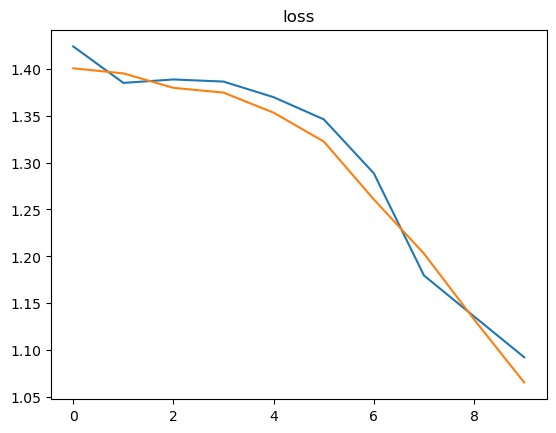

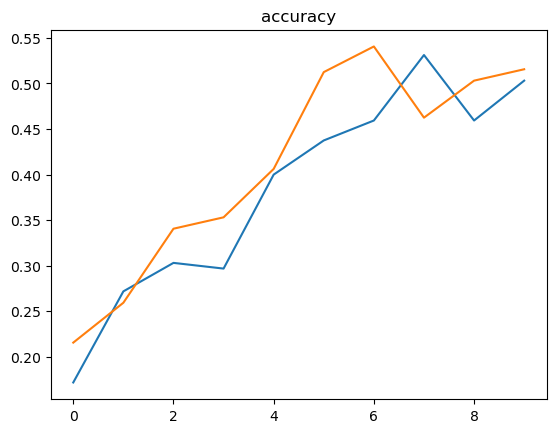

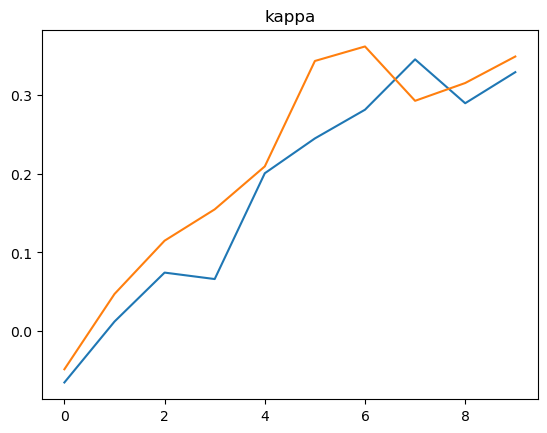

loss: 0.8974806666374207 iteration: 200/2000


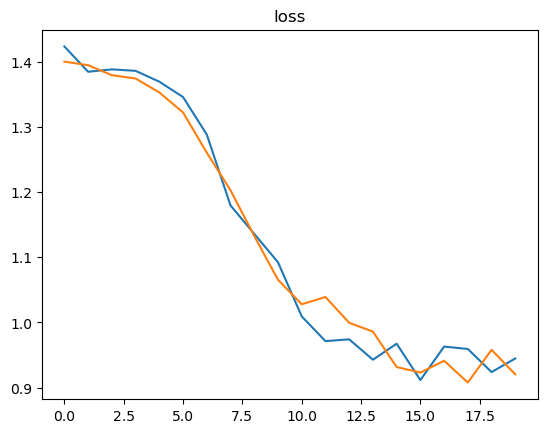

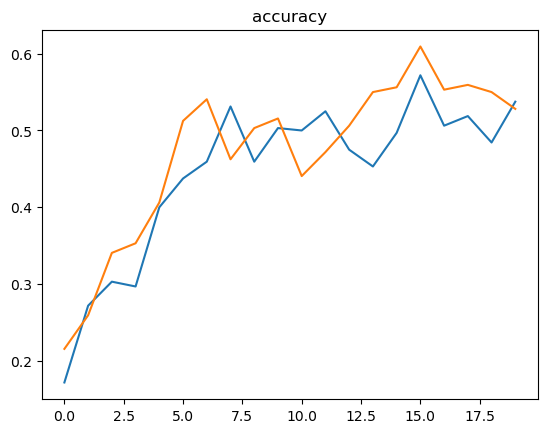

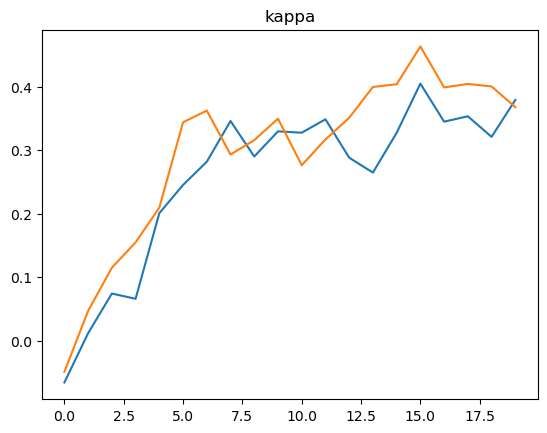

loss: 0.9640114903450012 iteration: 300/2000


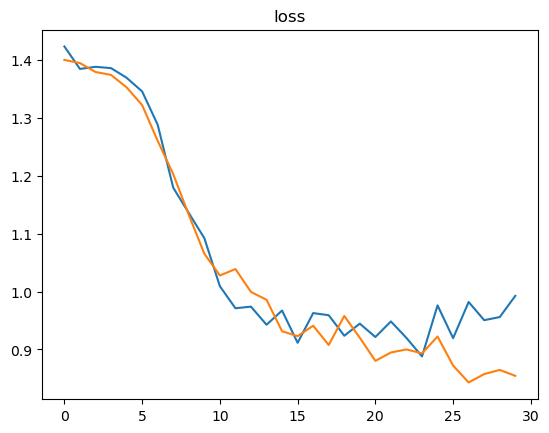

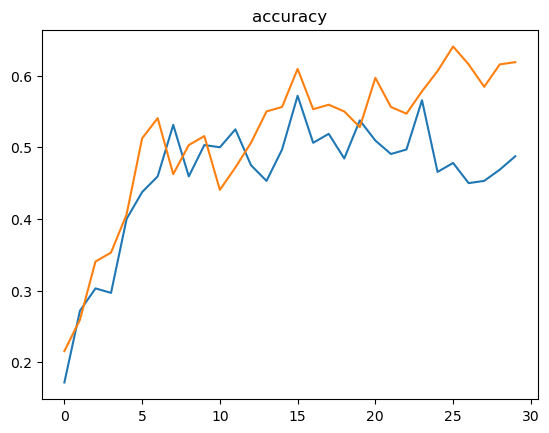

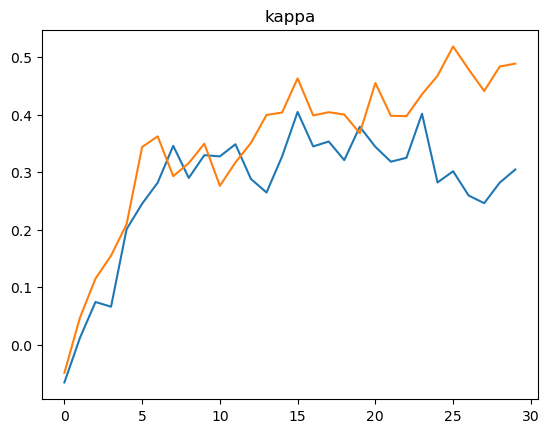

loss: 0.7236427068710327 iteration: 400/2000


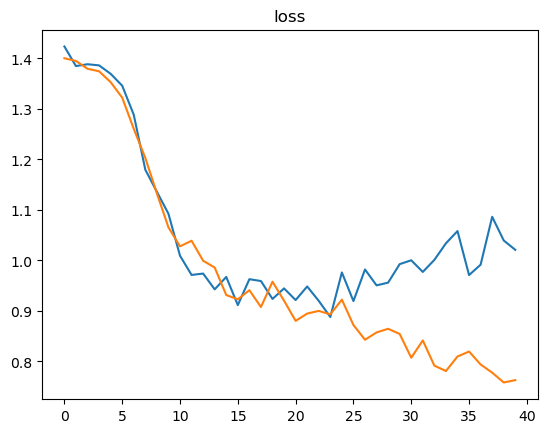

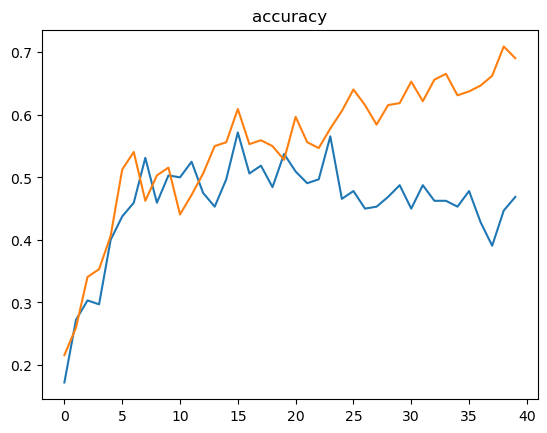

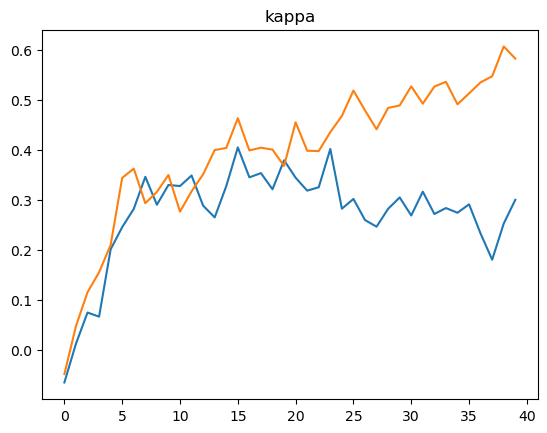

loss: 0.6294195652008057 iteration: 500/2000


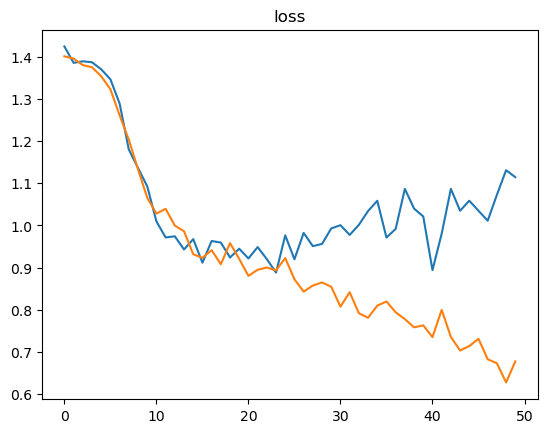

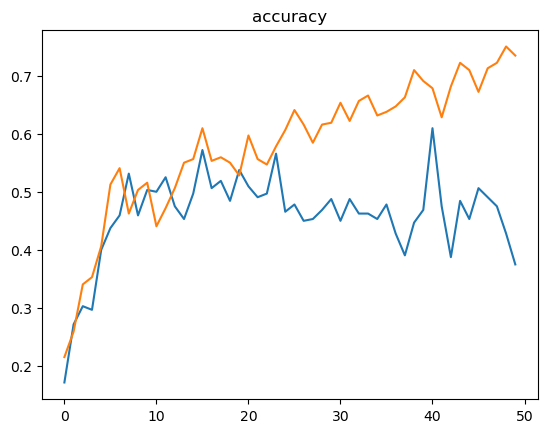

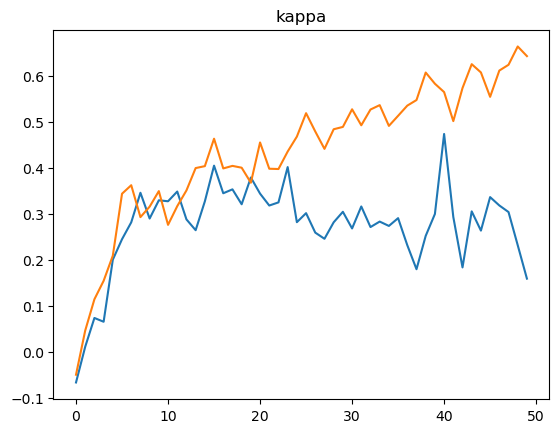

In [ ]:
from modules.TrainTester import TrainerTester

ud = []

#main-trianing-loop
for train_index, test_index in skf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    TrainerTester.train_loop(model, optimizer, X_train, y_train, X_test, y_test, 1, ud, batch_size=32, iterations=2000)

    out_values = TrainerTester.test_loop(model, X_test, y_test)
    break

In [ ]:
# model.load_state_dict(torch.load('model_states/test_model_states.txt'))
# torch.save(model.state_dict(), 'model_states/test_model_states.txt')

In [ ]:
# from modules.EdfHandler import EdfHandler
#
# epochs_list, labels_list = EdfHandler.getAllData(
#     [
#         "C:\\Users\\davi2\Desktop\\bci\\datasets_ufjf\\bci\\001.edf",
#         "C:\\Users\\davi2\Desktop\\bci\\datasets_ufjf\\bci\\002.edf",
#         "C:\\Users\\davi2\Desktop\\bci\\datasets_ufjf\\bci\\003.edf",
#         "C:\\Users\\davi2\Desktop\\bci\\datasets_ufjf\\bci\\004.edf",
#         "C:\\Users\\davi2\Desktop\\bci\\datasets_ufjf\\bci\\005.edf",
#         "C:\\Users\\davi2\Desktop\\bci\\datasets_ufjf\\bci\\006.edf",
#     ]
# )
#
# for epochs, labels in zip(epochs_list, labels_list):
#     labels = np.array(labels)
#     labels[labels == 6] = 0
#
#     data = epochs.get_data()
#     X = torch.tensor(data).to(dtype=torch.float32, device=device)
#     X = X[:,:,:-1]
#     y = torch.tensor(labels).to(dtype=torch.long, device=device)
#
#     print(X.shape[-1])
#
#     model = EEGNET(n_times=X.shape[-1], n_channels=len(epochs.picks), n_classes=len(set(labels)), kernel_length=epochs.info["sfreq"]//2)
#     model = model.to(device=device)
#
#     seed = 1330
#     splits = 5
#     lr=3e-4
#
#     skf = StratifiedKFold(n_splits=splits, random_state=seed, shuffle=True)
#
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#
#     ud = []
#
#     #main-trianing-loop
#     for train_index, test_index in skf.split(X, y):
#         X_train, X_test = X[train_index], X[test_index],
#         y_train, y_test = y[train_index], y[test_index]
#
#         TrainerTester.train_loop(model, optimizer, X_train, y_train, X_test, y_test, lr, ud, batch_size=16, iterations=2000)
#
#         out_values = TrainerTester.test_loop(model, X_test, y_test)
#         break

In [ ]:
# import re
# # visualize histograms
# plt.figure(figsize=(40, 20)) # width and height of the plot
# legends = []
# for name, params in model.named_parameters():
#     t = params.grad
#     # print(f'layer {name}: weight {tuple(params.shape)} | mean {t.mean()} | std {t.std()} | grad:data ratio { t.std() / params.std()}')
#     hy, hx = torch.histogram(t, density=True)
#     plt.plot(hx[:-1].detach(), hy.detach())
#     legends.append(f'{name} {tuple(params.shape)}')
# plt.legend(legends)
# plt.title('weights gradient distribution')
# plt.show()